# Using DSP to improve the accuracy of an EEG classifier

**Authors**
1. Kasra Lekan (kl5sq)
2. Derek Johnson (dej3tc)
3. Fiji Marcelin (fm4cg)

## Experimental Setup
**Signal Data**: We applied the a peak finding algorithm along with a bandpass and butterworth filter to sleep stage EEG data. This data is taken from a study looking at “slow-wave microconfinuity” during sleep [1]. 

**MNE Package**: The MNE package ...

In [2]:
from mne_data_setup import *

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /Users/derekjohnson/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


## Method 1: Peak Finder
### Theory
I implemented three peak finder algorithms (`naive_logical_find_peaks`, `naive_mathematical_find_peaks`, `peak_typing_finder`). Note that the first two naive implementations were designed by me while the other two follow from algorithms written by others. Also note that all of these algorithms can easily be converted to also identify valleys by multiplying the signal data by -1 before running the algorithm.

Each algorithm was compared to the baseline of the MNE implementation of peaking finding on a sin wave signal and the eeg data described above. 

1. `naive_logical_find_peaks` – Compares if values are greater than their neighbors in the signal. The number of neighbors in the comparison is controlled by a parameter.
2. `naive_mathematical_find_peaks` – Performs peak detection on three steps: 1. root mean square 2. peak to average ratios 3. first order logic. Thus, the method assumes that the underlying data follows a particular distribution, i.e. peaks will occur when the squared value of signal value divided by the root mean square (RMS) is larger than its neighbor values. By using a threshold, the algorithm attempts to handle any noise present in the dataset.
3. `peak_typing_finder` – This algorithm is noteable for its time efficiency and that it handles various kinds of peaks based on edge (e.g. None, 'rising', 'falling', 'both'). Otherwise, the algorithm is quite similar to naive_logical_find_peaks. 

An examination of the MNE algorithm's code shows that it follows the following algorithm. Note that some steps have been ommitted which handle edge cases.

0. Initialize a minimum threshold between peaks
    - Note that the thresholds I implemented were not between peaks. Rahter, they were minimum values for peaks or how much greater a peak had to be than its neighboring values.
1. Use `np.diff` to calculate the change between each point in the signal (derivative).
2. Find the indices where the derivative changes sign (peaks and valleys).
3. Create a temporary array with only the values at these indices along with the start and end points of the signal.
4. Find the minimum value in the array (`min_mag`).
5. Check if start and end points should be candidates for peaks.
6. Loop through peak candidates (peak, valley list)
    0. Initialize the minimum magnitude for peak (`temp_mag`) as `min_mag`.
    1. If the last value was a true peak, reset `temp_mag` to `min_mag`.
    2. If candidate value greater than its peer by the threshold ammount. Set a new temp_mag. Add to true peak list.
7. Return chosen candidates.

The step 6 is why it can handle noisy data better than any of my algorithms. If step 6 was removed, MNE's algorithm would be equivalent to `peak_typing_finder`.

### Implementation & Performance

#### MNE Baselines

In [3]:
from peak_finder import PeakFinder as pf

t = np.arange(0, 3, 0.01)
signal_sin = np.sin(np.pi*t) - np.sin(0.5*np.pi*t)
mne_sin_peak_locs, mne_sin_peak_mags = mne.preprocessing.peak_finder(signal_sin) 

signal_eeg = raw_train.get_data()[0]
format_percent = lambda x, y: np.round(len(x)/len(y), 4)
mne_eeg_peak_locs, mne_eeg_peak_mags = mne.preprocessing.peak_finder(raw_train.get_data()[0])

def success_metrics(results, signal='eeg', string=""):
    if signal == 'eeg':
        signal = signal_eeg
        mne_peak_locs = mne_eeg_peak_locs
    elif signal == 'sin':
        signal = signal_sin
        mne_peak_locs = mne_sin_peak_locs

    common_peaks = np.intersect1d(results, mne_peak_locs)
    common_peaks_len = len(common_peaks)

    true_positive_rate = format_percent(common_peaks, mne_peak_locs)

    results_len = len(results)
    peak_to_signal_ratio = format_percent(results, signal)

    actual_to_predicted_peak_count_ratio = format_percent(results, mne_peak_locs)

    print(string + f"Peaks: {results_len}, peak/signal: {peak_to_signal_ratio}, (actual)/(predicted) peaks : {actual_to_predicted_peak_count_ratio}, Intersect Num: {common_peaks_len} ({true_positive_rate})")
    return None

Found 2 significant peaks
Found 29454 significant peaks


**MNE Commentary**: The MNE algorithm performs well on noisy data while keeping time complexity low.

#### scipy.signal.find_peaks

In [4]:
from scipy.signal import find_peaks

success_metrics(mne_eeg_peak_locs, signal='eeg', string="MNE: ")
scipy_peaks_eeg, _ = find_peaks(signal_eeg)
success_metrics(scipy_peaks_eeg, signal='eeg')

print('\n')

success_metrics(mne_sin_peak_locs, signal='sin', string="MNE: ")
scipy_peaks_sin, _ = find_peaks(signal_sin)
success_metrics(scipy_peaks_sin, signal='sin')

MNE: Peaks: 29454, peak/signal: 0.0037, (actual)/(predicted) peaks : 1.0, Intersect Num: 29454 (1.0)
Peaks: 2069676, peak/signal: 0.2603, (actual)/(predicted) peaks : 70.2681, Intersect Num: 29451 (0.9999)


MNE: Peaks: 2, peak/signal: 0.0067, (actual)/(predicted) peaks : 1.0, Intersect Num: 2 (1.0)
Peaks: 2, peak/signal: 0.0067, (actual)/(predicted) peaks : 1.0, Intersect Num: 2 (1.0)


**Results Commentary**: In terms of time, scipy.signal.find_peaks clearly beats all other algorithms tested. Additionally, it performed poorly at distinguishing peaks in the noisy EEG dataset. The documentation from Scipy suggest to use a smoothing function before finding peaks in order to avoid this problem.

#### naive_logical_find_peaks

In [5]:
peaks_eeg = {}
success_metrics(mne_eeg_peak_locs, signal='eeg', string="MNE: ")
distances = [15, 35, 50, 100, 155]
for distance in distances:
    peaks_eeg[distance] = pf.naive_logical_find_peaks(signal_eeg, min_distance=distance)
    success_metrics(peaks_eeg[distance], signal='eeg', string=f"Distance: {distance}, ")

print('\n')

peaks_sin = {}
success_metrics(mne_sin_peak_locs, signal='sin', string="MNE: ")
for distance in distances:
    peaks_sin[distance] = pf.naive_logical_find_peaks(signal_sin, min_distance=distance)
    success_metrics(peaks_sin[distance], signal='sin', string=f"Distance: {distance}, ")

MNE: Peaks: 29454, peak/signal: 0.0037, (actual)/(predicted) peaks : 1.0, Intersect Num: 29454 (1.0)
Distance: 15, Peaks: 188047, peak/signal: 0.0237, (actual)/(predicted) peaks : 6.3844, Intersect Num: 28906 (0.9814)
Distance: 35, Peaks: 87758, peak/signal: 0.011, (actual)/(predicted) peaks : 2.9795, Intersect Num: 27407 (0.9305)
Distance: 50, Peaks: 63595, peak/signal: 0.008, (actual)/(predicted) peaks : 2.1591, Intersect Num: 25730 (0.8736)
Distance: 100, Peaks: 34871, peak/signal: 0.0044, (actual)/(predicted) peaks : 1.1839, Intersect Num: 21150 (0.7181)
Distance: 155, Peaks: 26413, peak/signal: 0.0033, (actual)/(predicted) peaks : 0.8968, Intersect Num: 18193 (0.6177)


MNE: Peaks: 2, peak/signal: 0.0067, (actual)/(predicted) peaks : 1.0, Intersect Num: 2 (1.0)
Distance: 15, Peaks: 2, peak/signal: 0.0067, (actual)/(predicted) peaks : 1.0, Intersect Num: 2 (1.0)
Distance: 35, Peaks: 2, peak/signal: 0.0067, (actual)/(predicted) peaks : 1.0, Intersect Num: 2 (1.0)
Distance: 50, Peaks

**Results Commentary**: In terms of time, naive_logical_find_peaks did not perform as well as MNE. Additionally, it performed poorly at distinguishing peaks in the noisy EEG dataset. 

#### naive_mathematical_find_peaks

In [6]:
success_metrics(mne_eeg_peak_locs, signal='eeg', string="MNE: ")
ind_eeg_naive_mathematical_find_peaks = pf.naive_mathematical_find_peaks(signal_eeg)
success_metrics(ind_eeg_naive_mathematical_find_peaks, signal='eeg')

print('\n')

success_metrics(mne_sin_peak_locs, signal='sin', string="MNE: ")
ind_sin_naive_mathematical_find_peaks = pf.naive_mathematical_find_peaks(signal_sin)
success_metrics(ind_sin_naive_mathematical_find_peaks, signal='sin')

MNE: Peaks: 29454, peak/signal: 0.0037, (actual)/(predicted) peaks : 1.0, Intersect Num: 29454 (1.0)
Peaks: 2128087, peak/signal: 0.2677, (actual)/(predicted) peaks : 72.2512, Intersect Num: 29070 (0.987)


MNE: Peaks: 2, peak/signal: 0.0067, (actual)/(predicted) peaks : 1.0, Intersect Num: 2 (1.0)
Peaks: 2, peak/signal: 0.0067, (actual)/(predicted) peaks : 1.0, Intersect Num: 1 (0.5)


**Results Commentary**: In terms of time, naive_mathematical_find_peaks performed similarly to MNE. However, it performed poorly at distinguishing peaks in the noisy EEG dataset with 72.25 times as many peaks identified compared to MNE. 

#### peak_typing_finder

In [7]:
minimum_height = 4e-5
edges = ['rising', 'falling', 'both', None]
success_metrics(mne_eeg_peak_locs, signal='eeg', string="MNE: ")
for edge in edges:
    ind_eeg_peak_typing_finder = pf.peak_typing_finder(signal_eeg, minimum_height=minimum_height, minimum_distance=1, edge=edge)
    success_metrics(ind_eeg_peak_typing_finder, signal='eeg', string=f"Edge: {edge}, ")

print('\n')

success_metrics(mne_sin_peak_locs, signal='sin', string="MNE: ")
for edge in edges:
    ind_sin_peak_typing_finder = pf.peak_typing_finder(signal_sin, minimum_height=minimum_height, minimum_distance=1, edge=edge)
    success_metrics(ind_sin_peak_typing_finder, signal='sin', string=f"Edge: {edge}, ")

MNE: Peaks: 29454, peak/signal: 0.0037, (actual)/(predicted) peaks : 1.0, Intersect Num: 29454 (1.0)
Edge: rising, Peaks: 161038, peak/signal: 0.0203, (actual)/(predicted) peaks : 5.4674, Intersect Num: 25484 (0.8652)
Edge: falling, Peaks: 161118, peak/signal: 0.0203, (actual)/(predicted) peaks : 5.4702, Intersect Num: 25323 (0.8597)
Edge: both, Peaks: 162401, peak/signal: 0.0204, (actual)/(predicted) peaks : 5.5137, Intersect Num: 25484 (0.8652)
Edge: None, Peaks: 159755, peak/signal: 0.0201, (actual)/(predicted) peaks : 5.4239, Intersect Num: 25323 (0.8597)


MNE: Peaks: 2, peak/signal: 0.0067, (actual)/(predicted) peaks : 1.0, Intersect Num: 2 (1.0)
Edge: rising, Peaks: 2, peak/signal: 0.0067, (actual)/(predicted) peaks : 1.0, Intersect Num: 2 (1.0)
Edge: falling, Peaks: 2, peak/signal: 0.0067, (actual)/(predicted) peaks : 1.0, Intersect Num: 2 (1.0)
Edge: both, Peaks: 2, peak/signal: 0.0067, (actual)/(predicted) peaks : 1.0, Intersect Num: 2 (1.0)
Edge: None, Peaks: 2, peak/signal:

**Results Commentary**: In terms of time, peak_typing_finder peformed as well or better than MNE. However, it performed moderately well at distinguishing peaks in the noisy EEG dataset with 5.47 times as many peaks identified compared to MNE while covering 86.5% of the peaks. The edge type did not significantly affect performance on this data, likely due to the noise in the EEG dataset.

@Derek and @Fiji

## Exploration of Butterworth Filters

In [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8311494/) paper, the network consists of two CNN modules that capture features from different perspectives. CNN with small filter sizes and strides is in charge of extracting detailed features and high-frequency information. On the contrary, CNN with larger sizes and strides is to capture low-frequency information, such as sleep waves.

In order to boost the classification accuracy, we will experiment with applying butterworth filters for low and high pass.

First we have to develop a Butterworth filter that can be applied to numpy arrays.
There is a [scipy version](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) that we can use to check our results when we are done to make sure they are what we would expect.

In order to actually implement the filter, we will follow the steps outlined in [this](https://www.dsprelated.com/showarticle/1119.php) article. This will allow us to get the numerator and denominator coefficients for a Butterworth low-pass filter with variable order, stop_frequency, and sampling frequency.

[this](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.filter) method may be useful for additional filtering.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data

### Designing a Butterworth filter

Butterworth filters are designed to have a frequency response that is flat in the passband. The number of poles in the filter (N), dictates how sharp of a slope is applied at the cutoff frequency. In their standard form, Butterworth filters are low-pass filters. However, they can be modified to be high-pass, band-pass, or band-stop filters.

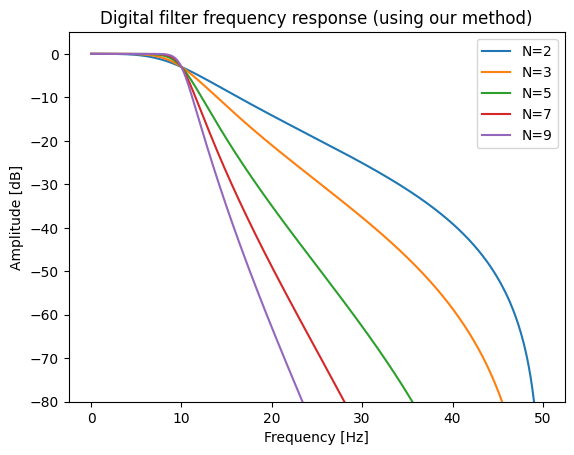

In [9]:
from typing import Tuple
from scipy import signal
from enum import Enum

class FilterType(Enum):
    LOWPASS = 1
    HIGHPASS = 2
    BANDPASS = 3
    BANDSTOP = 4

def butterworth(N: int, fc: float, fs: float, type: FilterType = FilterType.LOWPASS) -> Tuple[np.ndarray, np.ndarray]:
    """Return the numerator and denominator of the Butterworth filter.

    Args:
        N (int): filter order
        fc (float): cutoff frequency in Hz
        fs (float): sample frequency in Hz

    Returns:
        Tuple[np.ndarray, np.ndarray]: [b, a] the numerator and denominator coefficients
    """
    if type in [FilterType.BANDPASS, FilterType.BANDSTOP]:
        raise NotImplementedError("Bandpass and bandstop filters are not implemented.")
    if fc >= fs / 2:
        raise ValueError("Cutoff frequency must be less than half the sample frequency.")
    # Find the poles of the analog filter
    k = np.arange(1, N + 1)
    theta =  (2 * k - 1) * np.pi / (2 * N)
    pa_0 = -np.sin(theta) + 1j * np.cos(theta)
    # scale the poles in frequency
    Fc = fs/np.pi * np.tan(np.pi * fc / fs)
    pa = 2*np.pi*Fc
    if type == FilterType.LOWPASS:
        pa *= pa_0
    elif type == FilterType.HIGHPASS:
        pa /= pa_0
    # find the coefficients of the digital filter
    p = (1 + pa/(2*fs)) / (1 - pa/(2*fs))
    q = np.ones(N)
    if type == FilterType.LOWPASS:
        q *= -1

    a = np.poly(p)
    a = np.real(a)
    b = np.poly(q)
    if type == FilterType.LOWPASS:
        K = np.sum(a) / np.sum(b)
    if type == FilterType.HIGHPASS:
        m = np.arange(0, N + 1)
        K = np.sum((-1)**m * a) / np.sum((-1)**m * b)
    b = b*K
    return b, a

fig, ax = plt.subplots()
for N in [2, 3, 5, 7, 9]:
    b, a = butterworth(N, 10, 100)
    w, h = signal.freqz(b, a, fs=100)
    # convert w to Hz
    ax.plot(w, 20 * np.log10(abs(h)), label=f'N={N}')
ax.legend(loc='best')
ax.set_title('Digital filter frequency response (using our method)')
ax.set_ylim(-80, 5)
ax.set_ylabel('Amplitude [dB]')
ax.set_xlabel('Frequency [Hz]')
plt.show()

Lets compare our method with the results we obtain from the scipy version.

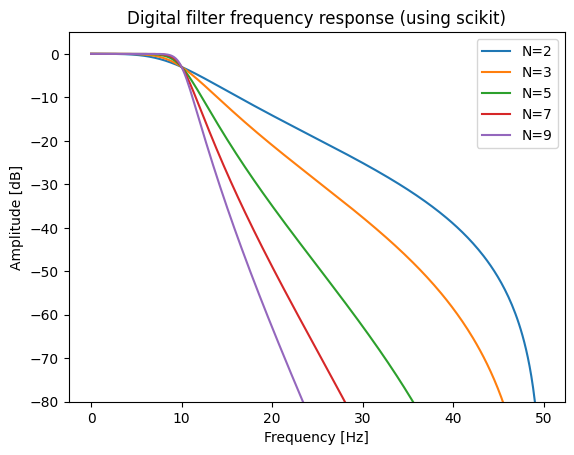

In [10]:
from scipy import signal

fig, ax = plt.subplots()
for N in [2, 3, 5, 7, 9]:
    b, a = signal.butter(N, 10, fs=100, btype="lowpass")
    w, h = signal.freqz(b, a, worN=256, fs=100)
    # convert w to Hz
    ax.plot(w, 20 * np.log10(abs(h)), label=f'N={N}')
ax.legend(loc='best')
ax.set_title('Digital filter frequency response (using scikit)')
ax.set_ylim(-80, 5)
ax.set_ylabel('Amplitude [dB]')
ax.set_xlabel('Frequency [Hz]')
plt.show()

The results from the scipy method look identical to the results from our method. This gives us high confidence that we have designed the filter correctly.

Now we can apply the filter parameters to a signal. We will create a signal with two sinusoidal components, one at a frequency of 10Hz and the other at 20Hz. We will apply a butterworth filter with a cutoff frequency of 15Hz. We would expect this to limit the output signal to just the 10Hz component.

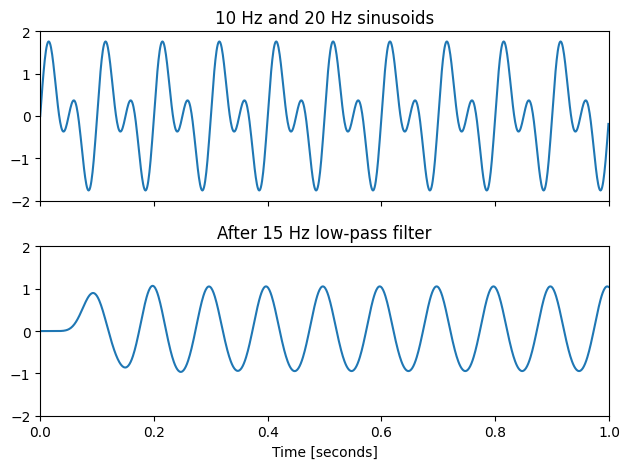

In [11]:
def iir_filter(b: np.ndarray, a: np.ndarray, x: np.ndarray) -> np.ndarray:
    """Apply an IIR filter to a signal. The info for this function was taken from the
    notes section of the scipy.signal.lfilter documentation.

    Args:
        b (np.ndarray): numerator coefficients
        a (np.ndarray): denominator coefficients
        x (np.ndarray): input signal

    Returns:
        np.ndarray: filtered signal
    """
    # For now we will have this condition. I do not this this needs to be true generally
    if len(b) != len(a):
        raise ValueError("The numerator and denominator must have the same length.")
    y = np.zeros_like(x)
    for i in range(len(b), len(x)):
        for j in range(len(b)):
            if i - j >= 0:
                y[i] += b[j] * x[i - j]
        for j in range(1, len(a)):
            if i - j >= 0:
                y[i] -= a[j] * y[i - j]
        y[i] /= a[0]
    return y

sample_frequency = 1000
t = np.linspace(0, 1, sample_frequency, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])
# butterworth filter with a cutoff frequncy of 15Hz
b, a = butterworth(10, 15, sample_frequency)
# TODO: figure out if we should use the scipy.signal.lfilter or our own implementation
filtered = iir_filter(b, a, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz low-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

This seems to be working as we would expect. We are only seeing the 10Hz signal.

Now we can experiment with using our butterworth filter as a high-pass filter. 

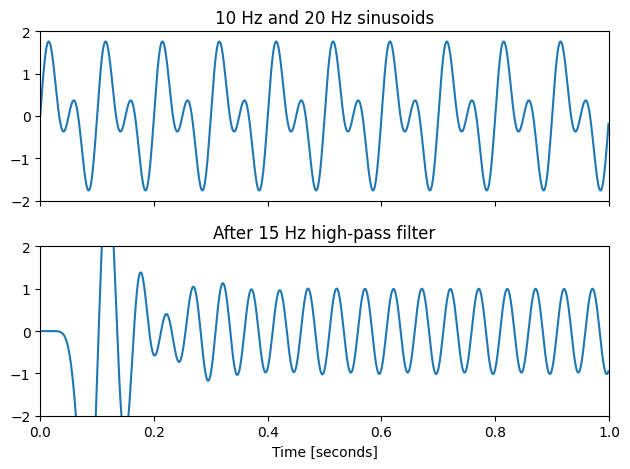

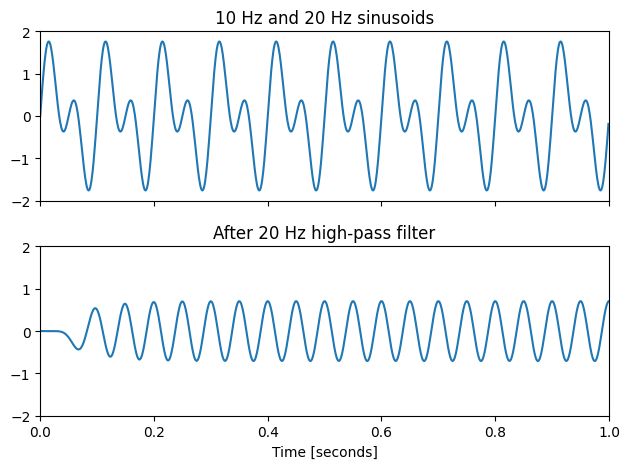

In [12]:
sample_frequency = 1000
t = np.linspace(0, 1, sample_frequency, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])

# butterworth filter with a cutoff frequncy of 15Hz
b, a = butterworth(10, 15, sample_frequency, type=FilterType.HIGHPASS)
filtered = iir_filter(b, a, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz high-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])

# butterworth filter with a cutoff frequncy of 20Hz
b, a = butterworth(10, 20, sample_frequency, type=FilterType.HIGHPASS)
filtered = iir_filter(b, a, sig)
ax2.plot(t, filtered)
ax2.set_title('After 20 Hz high-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

There is some weirdness that happens during the first 1/5th of the signal but I after that point it seems like the filter is working as expected. However, when we change the filter frequency to 20Hz, the filter looks much better.

## Modifying the EEG Data

Now that we have a way to apply both low-pass and high-pass filters to numpy arrays, lets look at the EEG data that we will be trying to classify.

In [13]:
from typing import List
ALICE, BOB = 0, 1
ANNOTATION_DESC_2_EVENT_ID = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

EVENT_ID = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

def fetch_epochs(subjects: List[int]) -> List[mne.Epochs]:
    user_files = fetch_data(subjects=subjects, recording=[1])
    epochs_list: List[mne.Epochs] = []
    for user_file in user_files:
        raw = mne.io.read_raw_edf(user_file[0], stim_channel='Event marker',
                                        misc=['Temp rectal'])
        
        annot = mne.read_annotations(user_file[1])
        raw.set_annotations(annot, emit_warning=True)
        # keep last 30-min wake events before sleep and first 30-min wake events after
        # sleep and redefine annotations on raw data
        annot.crop(annot[1]['onset'] - 30 * 60,
                        annot[-2]['onset'] + 30 * 60)
        raw.set_annotations(annot, emit_warning=False)
        events, _ = mne.events_from_annotations(
            raw, event_id=ANNOTATION_DESC_2_EVENT_ID, chunk_duration=30.)
        
        tmax = 30. - 1. / raw.info['sfreq']  # tmax in included

        epochs = mne.Epochs(raw=raw, events=events,
                                event_id=EVENT_ID, tmin=0., tmax=tmax, baseline=None)
        epochs_list.append(epochs)
    return epochs_list



In [14]:

#TODO: Figure out why there is already a high-pass filter applied to the data
# we can check the high-pass value by looking at the epochs_train.info['highpass']
[epochs_train, epochs_test] = fetch_epochs([ALICE, BOB])
# epochs.shape = (n_epochs, n_channels, n_times)
# n_ephochs = the number of 30-second epochs in the data
# n_channels = the number of channesl (e.g. EEG, EOG, EMG)
# n_times = the number of time points in each epoch

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /Users/derekjohnson/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/xt/9mglw7t50vxg54jk3lcl75700000gn/T/ipykernel_13024/1817167396.py:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /Users/derekjohnson/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/xt/9mglw7t50vxg54jk3lcl75700000gn/T/ipykernel_13024/1817167396.py:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated


Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 109 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Av

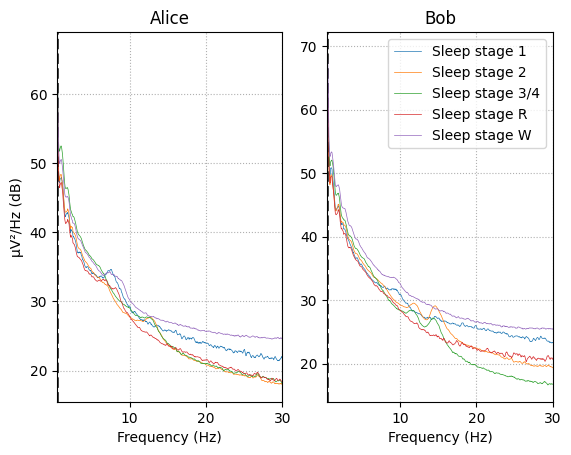

In [15]:
# visualize Alice vs. Bob PSD by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
stages = sorted(EVENT_ID.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['Alice', 'Bob'],
                             [epochs_train, epochs_test]):

    for stage, color in zip(stages, stage_colors):
        # getting all of the epochs of the specified stage and computing the PSD
        spectrum = epochs[stage].compute_psd(picks='eeg', fmin=0.5, fmax=30.)
        spectrum.plot(ci=None, color=color, axes=ax,
                      show=False, average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')
ax1.set(ylabel='µV²/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)
plt.show()

These plots show the frequency spectrum for 2 sleep study participants. The different colored lines represent the different sleep stages the participants were in. The frequency data was averaged across the 5 eeg sensors before it was plotted.

From [here](https://sapienlabs.org/lab-talk/pitfalls-of-filtering-the-eeg-signal/) we see that it is common to filter out frequencies higher than 40Hz and lower than 1Hz for EEG data.
The classifier we will be training in later steps only looks at data between 0.5Hz and 30Hz.
Thus, we will start the filtering by applying a lowpass filter with a cutoff of 20Hz and a highpass filter with a cutoff of 1Hz.
The goal of this filtering will be to further separate the sleep stages in the frequency domain.
We will perform this filtering on the 5 eeg channels and see how this effects the frequency plots.

In [23]:
from scipy.signal import lfilter

sample_frequency = epochs_train.info["sfreq"] # 100Hz
# make a low-pass filter with a cutoff frequency of 40Hz
bl, al = butterworth(5, 20, sample_frequency, type=FilterType.LOWPASS)
lowpass = lambda x: lfilter(bl, al, x)
# make a hi-pass filter with a cutoff frequency of 1Hz
bh, ah = butterworth(10, 1, sample_frequency, type=FilterType.HIGHPASS)
highpass = lambda x: lfilter(bh, ah, x)
# apply the functions to the channels of the epochs
epochs_train_filtered = epochs_train.copy()
epochs_train_filtered.load_data().apply_function(lowpass, picks='eeg')
epochs_train_filtered.load_data().apply_function(highpass, picks='eeg')

epochs_test_filtered = epochs_test.copy()
epochs_test_filtered.load_data().apply_function(lowpass, picks='eeg')
epochs_test_filtered.load_data().apply_function(highpass, picks='eeg')

Loading data for 841 events and 3000 original time points ...
Loading data for 1103 events and 3000 original time points ...


Number of events,1103
Events,Sleep stage 1: 109Sleep stage 2: 562Sleep stage 3/4: 105Sleep stage R: 170Sleep stage W: 157
Time range,0.000 – 29.990 sec
Baseline,off


Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...


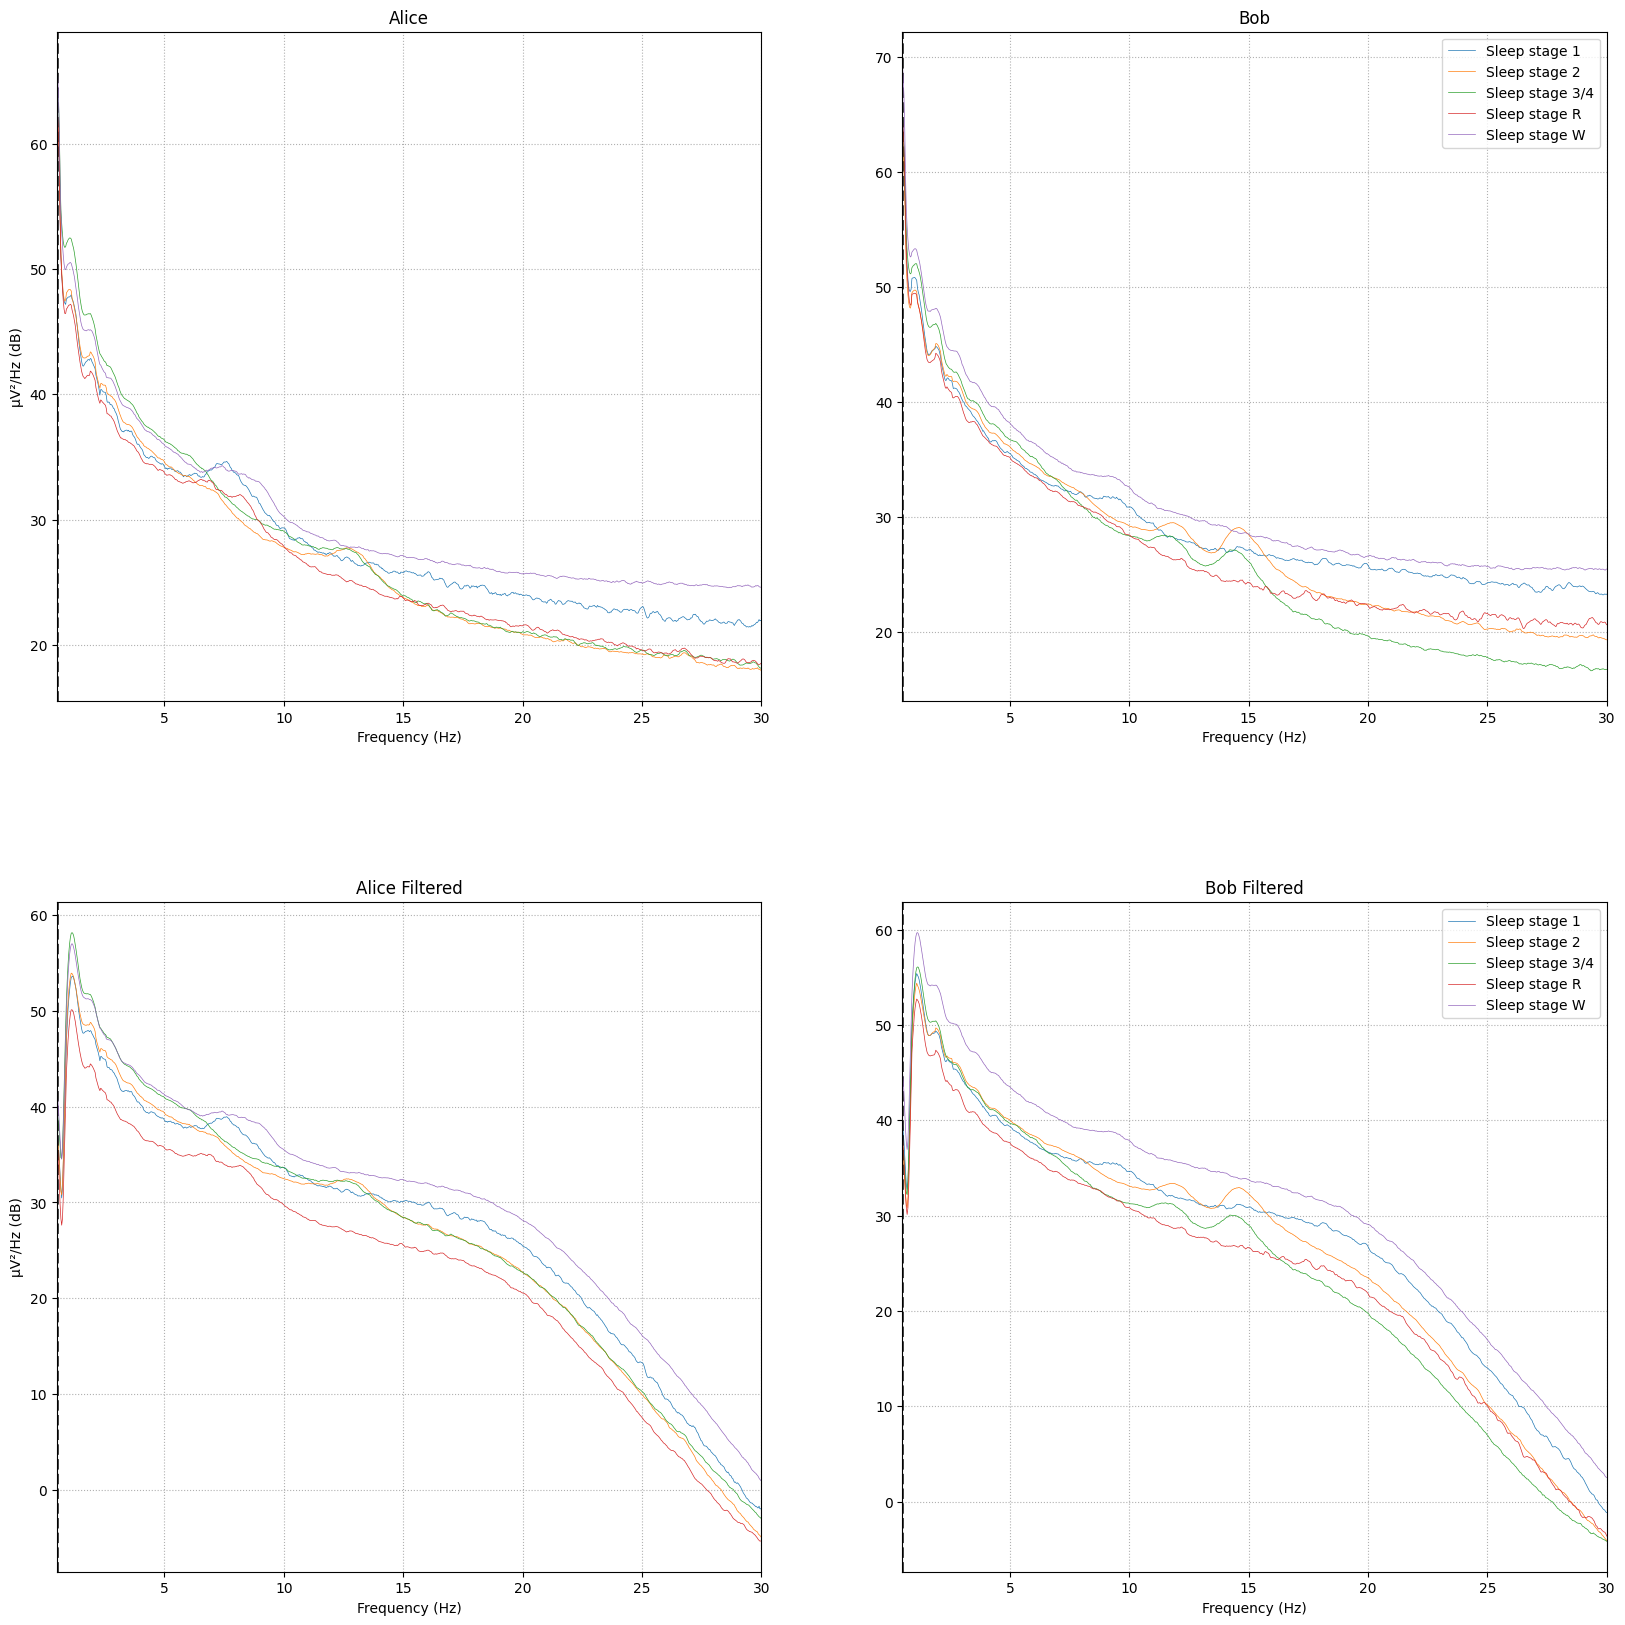

In [18]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))

# iterate over the subjects
def plot_epoch_psd(epochs, ax):
    stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    stages = sorted(EVENT_ID.keys())
    for stage, color in zip(stages, stage_colors):
        # getting all of the epochs of the specified stage and computing the PSD
        spectrum = epochs[stage].compute_psd(picks='eeg', fmin=0.5, fmax=30., verbose="error")
        spectrum.plot(ci=None, color=color, axes=ax,
                      show=False, average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')


for ax, title, epochs in zip([ax1, ax2, ax3, ax4],
                             ['Alice', 'Bob', 'Alice Filtered', 'Bob Filtered'],
                             [epochs_train, epochs_test, epochs_train_filtered, epochs_test_filtered]):
    plot_epoch_psd(epochs, ax)

ax1.set(ylabel='µV²/Hz (dB)')
ax2.legend(ax1.lines[2::3], stages)
ax3.set(ylabel='µV²/Hz (dB)')
ax4.legend(ax1.lines[2::3], stages)
plt.show()

From looking at the frequency plots generated, it seems like we have succeeded in increasing separation in the sleep stages.
Hopefully, this will result in better classification accuracy.

In [19]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, (n_freq_bands * n_eeg_channels)]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}
    # picks limits the channels to only eeg ones
    # fmin and fmax define the frequency range of interest
    # epochs.shape = (n_epochs, n_channels, n_times)
    spectrum = epochs.compute_psd(picks='eeg', fmin=0.5, fmax=30.)
    # spectrum.shape = (n_epochs, n_channels - (non eeg chanels), n_freqs)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # psds.shape = spectrum.shape, freqs.shape = (n_freqs,)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score with unmodified data: {}".format(acc))

Loading data for 841 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1103 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 0.6745240253853128


In [21]:
# Train
y_train = epochs_train_filtered.events[:, 2]
pipe.fit(epochs_train_filtered, y_train)

# Test
y_pred = pipe.predict(epochs_test_filtered)

# Assess the results
y_test = epochs_test_filtered.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score for filtered data: {}".format(acc))

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 0.6962828649138713


### Butterworth Filtering Results

We have observed an increase in classification accuracy of more than 2% by applying a high-pass filter at 1Hz and a low-pass filter at 20Hz.

### Fine-Tuning filter parameters
Now, we will experiment with different filter parameters. We will start by applying high-pass and low-pass filters separately and seeing how the classification accuracy is affected.

In [ ]:
sample_frequency = epochs_train.info["sfreq"] # 100Hz

low_pass_cutoffs = [5, 10, 15, 20, 25]
for cutoff in low_pass_cutoffs:
    bl, al = butterworth(5, cutoff, sample_frequency, type=FilterType.LOWPASS)
    lowpass = lambda x: lfilter(bl, al, x)

    # apply the functions to the channels of the epochs
    epochs_train_filtered = epochs_train.copy()
    epochs_train_filtered.load_data().apply_function(lowpass, picks='eeg')

    epochs_test_filtered = epochs_test.copy()
    epochs_test_filtered.load_data().apply_function(lowpass, picks='eeg')


## Classification Experiment Results

## Challenges
1. Handling Noisy Data: Discovered that the most effective peak algorithms are domain specific and that noise-robust algorithms are not the norm. Even popular packages like Scipy do not use a noisy peak finder but rather suggests users either use a smoothing function or avail themselves of the provided tools to specify typical features of the kind of signal you are working with such as peak prominences. 

## Work Breakdown

Kasra Lekan: 
- Coding experimental setup (including background MNE research how to modify underlying data)
- Peak Detection Algorithm

Derek Johnson: 
- Butterworth Filter

Fiji Marcelin: 
- Band Pass Filter

All:
- Combining filters and testing classification accuracy

## References
1. B. Kemp, A. H. Zwinderman, B. Tuk, H. A. C. Kamphuisen, and J. J. L. Oberyé. Analysis of a sleep-dependent neuronal feedback loop: the slow-wave microcontinuity of the EEG. IEEE Transactions on Biomedical Engineering, 47(9):1185–1194, 2000. doi:10.1109/10.867928.
    Dataset for analysis
2. https://mne.tools/stable/index.html
    Implementation of foundational EEG signals pipleline
3. https://neuraldatascience.io/intro.html
    E-book that covers analysis of EEG data in the frequency domain.
4. https://en.wikipedia.org/wiki/Band-pass_filter
5. https://en.wikipedia.org/wiki/Butterworth_filter
6. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
7. http://www.scholarpedia.org/article/Electroencephalogram
    An overview of electroencephologram (EEG) collection. 
